# Setup

This notebook copies and build out Part III of `jeff_classifier.py` - that is, the section that trains and tests a classifier on the generated data.

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from helpers import disaggregated_df
from helpers import aggregated_df
from helpers import dummify_df

from helpers import score_metrics
from helpers import all_scoring_metrics

from helpers import draw_roc

%matplotlib inline
sns.set(font='monospace')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc:fpr',
                'roc:tpr',
                'roc:auc',
                'roc:thresholds'
               ]
price_cols = ['duration_in_mins','price','price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 103)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## First Classification

Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 101)


In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(np.mean(etc_metrics.roc_auc))
etc_metrics.loc[:, eval_columns]

0.862091503267974


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc:fpr,roc:tpr,roc:auc,roc:thresholds
0,0.222222,0.877193,0.960784,0.166667,0.776144,"[0.0, 0.0392156862745, 1.0]","[0.0, 0.166666666667, 1.0]",0.563725,"[2, 1, 0]"
1,0.000000,0.824561,0.921569,0.000000,0.857843,"[0.0, 0.078431372549, 1.0]","[0.0, 0.0, 1.0]",0.460784,"[2, 1, 0]"
2,0.000000,0.859649,0.960784,0.000000,0.542484,"[0.0, 0.0392156862745, 1.0]","[0.0, 0.0, 1.0]",0.480392,"[2, 1, 0]"
3,0.166667,0.824561,0.901961,0.166667,0.888889,"[0.0, 0.0980392156863, 1.0]","[0.0, 0.166666666667, 1.0]",0.534314,"[2, 1, 0]"
4,0.142857,0.789474,0.862745,0.166667,0.830065,"[0.0, 0.137254901961, 1.0]","[0.0, 0.166666666667, 1.0]",0.514706,"[2, 1, 0]"
5,0.285714,0.912281,1.000000,0.166667,0.936275,"[0.0, 1.0]","[0.166666666667, 1.0]",0.583333,"[True, False]"
6,0.000000,0.877193,0.980392,0.000000,0.901961,"[0.0, 0.0196078431373, 1.0]","[0.0, 0.0, 1.0]",0.490196,"[2, 1, 0]"
7,0.285714,0.912281,1.000000,0.166667,0.887255,"[0.0, 1.0]","[0.166666666667, 1.0]",0.583333,"[True, False]"
8,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 1.0]","[1.0, 1.0]",1.000000,"[True, False]"
9,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 1.0]","[1.0, 1.0]",1.000000,"[True, False]"


In [7]:
etc_metrics.loc[:,  sorted(set(etc_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

images_count:75%          0.043235
images_count:25%          0.040955
images_count:50%          0.031925
age:min                   0.031689
flag_Juvenile             0.029135
age:mean                  0.025070
age:max                   0.024921
n_ads                     0.024606
age:count                 0.024344
n_incall_and_outcall      0.022948
n_distinct_locations      0.022501
images_count:min          0.022198
n_incall                  0.021526
flag_Foreign Providers    0.021120
images_count:mean         0.020814
age:75%                   0.020812
age:std                   0.020452
age:50%                   0.020345
age:25%                   0.019794
location_tree_length      0.019124
dtype: float64

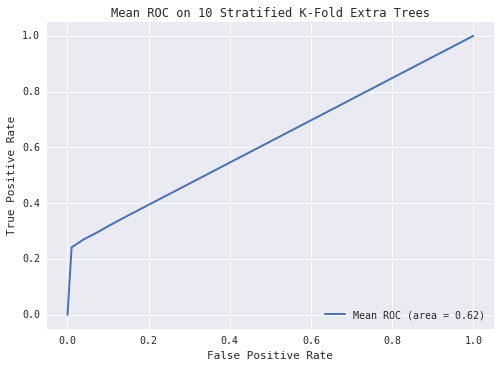

In [8]:
draw_roc(etc_metrics, 'Extra Trees')

In [9]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(np.mean(rf_metrics.roc_auc))
rf_metrics.loc[:, eval_columns]

0.8517973856209149


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc:fpr,roc:tpr,roc:auc,roc:thresholds
0,0.166667,0.824561,0.901961,0.166667,0.815359,"[0.0, 0.0980392156863, 1.0]","[0.0, 0.166666666667, 1.0]",0.534314,"[2, 1, 0]"
1,0.000000,0.842105,0.941176,0.000000,0.753268,"[0.0, 0.0588235294118, 1.0]","[0.0, 0.0, 1.0]",0.470588,"[2, 1, 0]"
2,0.000000,0.859649,0.960784,0.000000,0.517974,"[0.0, 0.0392156862745, 1.0]","[0.0, 0.0, 1.0]",0.480392,"[2, 1, 0]"
3,0.153846,0.807018,0.882353,0.166667,0.892157,"[0.0, 0.117647058824, 1.0]","[0.0, 0.166666666667, 1.0]",0.524510,"[2, 1, 0]"
4,0.000000,0.754386,0.843137,0.000000,0.833333,"[0.0, 0.156862745098, 1.0]","[0.0, 0.0, 1.0]",0.421569,"[2, 1, 0]"
5,0.285714,0.912281,1.000000,0.166667,0.965686,"[0.0, 1.0]","[0.166666666667, 1.0]",0.583333,"[True, False]"
6,0.250000,0.894737,0.980392,0.166667,0.852941,"[0.0, 0.0196078431373, 1.0]","[0.0, 0.166666666667, 1.0]",0.573529,"[2, 1, 0]"
7,0.250000,0.894737,0.980392,0.166667,0.887255,"[0.0, 0.0196078431373, 1.0]","[0.0, 0.166666666667, 1.0]",0.573529,"[2, 1, 0]"
8,0.923077,0.982143,0.980000,1.000000,1.000000,"[0.0, 0.02, 1.0]","[0.0, 1.0, 1.0]",0.990000,"[2, 1, 0]"
9,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 1.0]","[1.0, 1.0]",1.000000,"[True, False]"


In [10]:
rf_metrics.loc[:,  sorted(set(rf_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

age:min                             0.046059
age:count                           0.044118
age:mean                            0.039464
similar_images_count:75%            0.039012
images_count:75%                    0.031607
exp_ads_from_simimages_count:75%    0.029192
age:std                             0.029164
flag_Juvenile                       0.028808
images_count:mean                   0.025779
n_ads                               0.025202
age:max                             0.025019
similar_images_count:25%            0.024877
images_count:max                    0.022344
exp_ads_from_simimages_count:50%    0.022234
age:50%                             0.021938
similar_images_count:count          0.021391
exp_ads_from_simimages_count:25%    0.020995
age:25%                             0.019817
similar_images_count:50%            0.019328
images_count:count                  0.019056
dtype: float64

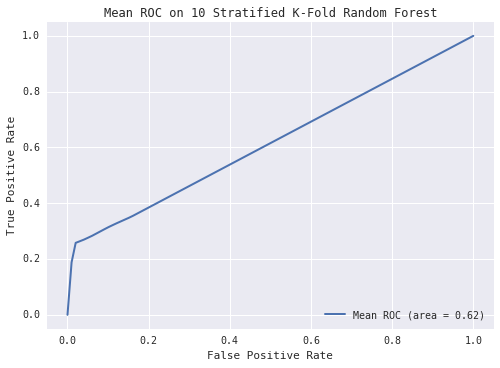

In [11]:
draw_roc(rf_metrics, 'Random Forest')

## Second Classification
The same as above, but exclude price variables

In [12]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols - price_cols - duration_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 77)


In [13]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(np.mean(etc_metrics.roc_auc))
etc_metrics.loc[:, eval_columns]

0.8764705882352942


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc:fpr,roc:tpr,roc:auc,roc:thresholds
0,0.222222,0.877193,0.960784,0.166667,0.831699,"[0.0, 0.0392156862745, 1.0]","[0.0, 0.166666666667, 1.0]",0.563725,"[2, 1, 0]"
1,0.000000,0.842105,0.941176,0.000000,0.848039,"[0.0, 0.0588235294118, 1.0]","[0.0, 0.0, 1.0]",0.470588,"[2, 1, 0]"
2,0.000000,0.859649,0.960784,0.000000,0.606209,"[0.0, 0.0392156862745, 1.0]","[0.0, 0.0, 1.0]",0.480392,"[2, 1, 0]"
3,0.153846,0.807018,0.882353,0.166667,0.888889,"[0.0, 0.117647058824, 1.0]","[0.0, 0.166666666667, 1.0]",0.524510,"[2, 1, 0]"
4,0.142857,0.789474,0.862745,0.166667,0.823529,"[0.0, 0.137254901961, 1.0]","[0.0, 0.166666666667, 1.0]",0.514706,"[2, 1, 0]"
5,0.285714,0.912281,1.000000,0.166667,0.954248,"[0.0, 1.0]","[0.166666666667, 1.0]",0.583333,"[True, False]"
6,0.250000,0.894737,0.980392,0.166667,0.933007,"[0.0, 0.0196078431373, 1.0]","[0.0, 0.166666666667, 1.0]",0.573529,"[2, 1, 0]"
7,0.285714,0.912281,1.000000,0.166667,0.879085,"[0.0, 1.0]","[0.166666666667, 1.0]",0.583333,"[True, False]"
8,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 1.0]","[1.0, 1.0]",1.000000,"[True, False]"
9,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 1.0]","[1.0, 1.0]",1.000000,"[True, False]"


In [14]:
etc_metrics.loc[:,  sorted(set(etc_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

images_count:25%          0.038113
images_count:75%          0.037506
images_count:50%          0.034573
flag_Juvenile             0.033525
n_incall                  0.031228
age:min                   0.029387
n_ads                     0.028312
age:max                   0.028137
age:count                 0.027361
n_incall_and_outcall      0.026062
age:mean                  0.024112
location_tree_length      0.023603
images_count:min          0.022700
n_distinct_locations      0.021889
n_cooccurring_phones      0.021886
images_count:mean         0.021660
flag_Foreign Providers    0.021613
age:75%                   0.021558
images_count:max          0.021446
age:25%                   0.021083
dtype: float64

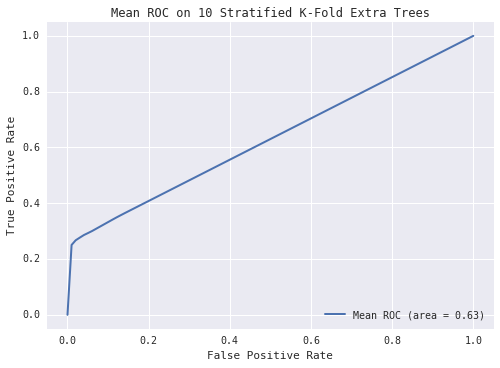

In [15]:
draw_roc(etc_metrics, 'Extra Trees')

In [16]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(np.mean(rf_metrics.roc_auc))
rf_metrics.loc[:, eval_columns]

0.8629084967320264


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc:fpr,roc:tpr,roc:auc,roc:thresholds
0,0.181818,0.842105,0.921569,0.166667,0.833333,"[0.0, 0.078431372549, 1.0]","[0.0, 0.166666666667, 1.0]",0.544118,"[2, 1, 0]"
1,0.000000,0.842105,0.941176,0.000000,0.776144,"[0.0, 0.0588235294118, 1.0]","[0.0, 0.0, 1.0]",0.470588,"[2, 1, 0]"
2,0.000000,0.859649,0.960784,0.000000,0.545752,"[0.0, 0.0392156862745, 1.0]","[0.0, 0.0, 1.0]",0.480392,"[2, 1, 0]"
3,0.285714,0.824561,0.882353,0.333333,0.885621,"[0.0, 0.117647058824, 1.0]","[0.0, 0.333333333333, 1.0]",0.607843,"[2, 1, 0]"
4,0.000000,0.754386,0.843137,0.000000,0.831699,"[0.0, 0.156862745098, 1.0]","[0.0, 0.0, 1.0]",0.421569,"[2, 1, 0]"
5,0.000000,0.894737,1.000000,0.000000,0.934641,"[0.0, 1.0]","[0.0, 1.0]",0.500000,"[1, 0]"
6,0.250000,0.894737,0.980392,0.166667,0.895425,"[0.0, 0.0196078431373, 1.0]","[0.0, 0.166666666667, 1.0]",0.573529,"[2, 1, 0]"
7,0.285714,0.912281,1.000000,0.166667,0.926471,"[0.0, 1.0]","[0.166666666667, 1.0]",0.583333,"[True, False]"
8,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 1.0]","[1.0, 1.0]",1.000000,"[True, False]"
9,1.000000,1.000000,1.000000,1.000000,1.000000,"[0.0, 1.0]","[1.0, 1.0]",1.000000,"[True, False]"


In [17]:
rf_metrics.loc[:,  sorted(set(rf_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

age:min                             0.070174
age:count                           0.046596
similar_images_count:25%            0.037007
age:mean                            0.033906
similar_images_count:50%            0.032063
exp_ads_from_simimages_count:50%    0.028150
n_ads                               0.026715
age:std                             0.026297
similar_images_count:75%            0.026280
age:max                             0.025491
flag_Juvenile                       0.025414
images_count:50%                    0.025269
images_count:mean                   0.025008
exp_ads_from_simimages_count:25%    0.022614
images_count:max                    0.022430
images_count:75%                    0.019835
age:50%                             0.019779
images_count:count                  0.019257
similar_images_count:count          0.019256
location_tree_length                0.019221
dtype: float64

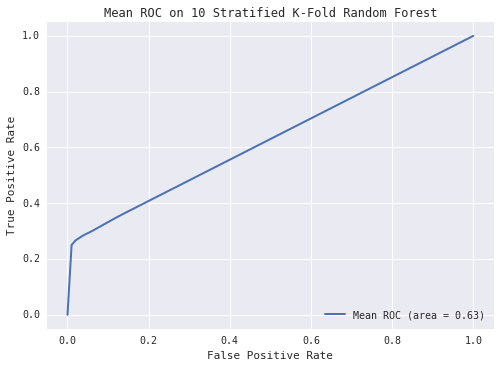

In [18]:
draw_roc(etc_metrics, 'Random Forest')